# 01 DOCUMENTATION_KADCYLA _Deseaon.sas

In [1]:
%load_ext rpy2.ipython

In [2]:
%R require(ggplot2); require(tidyr); require(minpack.lm)

/Users/faruqia/anaconda3/envs/ppm-r-env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/Users/faruqia/anaconda3/envs/ppm-r-env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: tidyr

  warnings.warn(x, RRuntimeWarning)
/Users/faruqia/anaconda3/envs/ppm-r-env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: minpack.lm

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
import numpy as np
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import Counter

In [4]:
def add_time_variable_zip3(dataframe):
    locator3 = set()
    count3  = 1
    count_list_col = []
    for x in dataframe['ZIP3']:
        if x not in locator3:
            count3 = 1
            count_list_col.append(count3)
            #print (x, count3)
        else:
            count3 += 1
            count_list_col.append(count3)
            #print (x, count3)
        locator3.add(x)
    return count_list_col

In [5]:
zip3_kadcyla_w_media = pd.read_sas('../MMix_Model/Tables/zip3_kadcyla_w_media.sas7bdat', format='sas7bdat',
                    index=None, iterator=False, encoding = 'latin-1')

#ARRAY NUMS _NUMERIC_;
#DO OVER NUMS;
#IF NUMS = . THEN NUMS=0;
#IF NUMS < 0 THEN NUMS=0;

# Fill NAs with zeros
zip3_kadcyla_w_media = zip3_kadcyla_w_media.fillna(0)
zip3_kadcyla_w_media[list(zip3_kadcyla_w_media.columns[2:])] = zip3_kadcyla_w_media[list(zip3_kadcyla_w_media.columns[2:])].apply(pd.to_numeric)

# Set negative values to zero for sales. DDD data 
zip3_kadcyla_w_media['KADCYLA_SALES'] = zip3_kadcyla_w_media['KADCYLA_SALES'].clip(lower=0)

#zip3_kadcyla_w_media.where(zip3_kadcyla_w_media < 0, 0)

In [6]:
#PROC SORT DATA=ZIP3_KADCYLA_W_MEDIA out=ZIP3_KADCYLA_W_MEDIA_2;
#BY ZIP3 MONTH;
zip3_kadcyla_w_media_2 = zip3_kadcyla_w_media.sort_values(by=['ZIP3', 'MONTH'])

In [7]:
#/*Deseasonalize by quarter*/
#PROC TIMESERIES data= ZIP3_KADCYLA_W_MEDIA_2 OUTDECOMP=DECOMPOSED SEASONALITY=3;
# BY ZIP3;
# var KADCYLA_SALES;
# DECOMP TCC SC SA/ MODE=ADD;
    
result = seasonal_decompose(zip3_kadcyla_w_media_2['KADCYLA_SALES'], model='additive', freq=3)
zip3_kadcyla_w_media_2['KADCYLA_SALES_SC']  = result.seasonal

#Original sales - SC
zip3_kadcyla_w_media_2['KADCYLA_SALES_SA'] = zip3_kadcyla_w_media_2['KADCYLA_SALES'] - zip3_kadcyla_w_media_2['KADCYLA_SALES_SC']


# KADCYLA_SALES_SA column needs to be added 
#KADCYLA_SALES is decomposing 

In [8]:
#data ZIP3_KADCYLA_W_MEDIA_3;
#  set ZIP3_KADCYLA_W_MEDIA_2;
#  TIMEID + 1;
#  by zip3;
#  if first.zip3 then TIMEID = 1; 

zip3_kadcyla_w_media_3 = zip3_kadcyla_w_media_2.copy()
zip3_kadcyla_w_media_3['TIMEID'] = pd.Series(add_time_variable_zip3(zip3_kadcyla_w_media_3)).values

#zip3_kadcyla_w_media_3['ZIP3'].map(add_time_var_zip3(zip3_kadcyla_w_media_3))

In [9]:
#create table ZIP3_KADCYLA_W_MEDIA_4 AS 
#/*Only TCC, SC and SA are used here*/
#/*SA = Seasonally adjusted;
#TCC = Trend;
#SC= seasonality
#SA= TCC + irregular;
#SA = Actual - seasonality;
#Actual = SA + SEASONALITY = TCC + IRR +SEASONALITY
#*/
#select A.*, /*B.TCC AS KADCYLA_SALES_T, SC AS KADCYLA_SALES_S,*/ SA AS KADCYLA_SALES_SA 
#from ZIP3_KADCYLA_W_MEDIA_3 A
#LEFT JOIN DECOMPOSED B
#ON A.ZIP3 = B.ZIP3 AND A.TIMEID = B._TIMEID_;

# Not implementing since already seems implemented

In [10]:
#DATA ZIP3_KADCYLA_W_MEDIA_4;
#SET ZIP3_KADCYLA_W_MEDIA_4;
#IF KADCYLA_SALES_SA <0 THEN KADCYLA_SALES_SA=0;

zip3_kadcyla_w_media_4 = zip3_kadcyla_w_media_3.copy()
zip3_kadcyla_w_media_4['KADCYLA_SALES_SA'] = zip3_kadcyla_w_media_4['KADCYLA_SALES_SA'].clip(lower=0)

In [11]:
#PROC EXPAND DATA=ZIP3_KADCYLA_W_MEDIA_4 OUT=ZIP3_KADCYLA_W_MEDIA_5 METHOD = NONE; 
#BY ZIP3;
#ID MONTH; 
#CONVERT KADCYLA_SALES_SA = KADCYLA_SALES_SA_L1  / TRANSFORMOUT=(LAG 1);

zip3_kadcyla_w_media_5 = zip3_kadcyla_w_media_4.copy()
# Create lag variable
zip3_kadcyla_w_media_5['KADCYLA_SALES_SA_L1'] = zip3_kadcyla_w_media_4['KADCYLA_SALES_SA'].shift()

In [12]:
#DATA DOC.ZIP3_KADCYLA_S1 (drop=timeid);
#SET ZIP3_KADCYLA_W_MEDIA_5;
#WHERE 201501<=MONTH<=201509;

zip3_kadcyla_w_media_5 = zip3_kadcyla_w_media_5[zip3_kadcyla_w_media_5['MONTH'].between(
    201501, 201509, inclusive=True)]


# 02B DOCUMENTATION_KADCYLA_ADSTOCK.sas

In [13]:
#data ZIP3_KADCYLA_S1;
#SET DOC.ZIP3_KADCYLA_S1;
#retain TIME;
#if first.zip3 then TIME = 1; 
#else TIME = TIME +1;
#by zip3;

zip3_kadcyla_s1 = pd.read_sas('../MMix_Model/Tables/zip3_kadcyla_s1.sas7bdat', format='sas7bdat',
                    index=None, iterator=False, encoding = 'latin-1')

zip3_kadcyla_s1['TIME'] = pd.Series(add_time_variable_zip3(zip3_kadcyla_s1)).values

#zip3_kadcyla_s1['ZIP3'].map(add_time_var_zip3(zip3_kadcyla_s1))

In [14]:
#proc transpose data=ZIP3_KADCYLA_S1 out=ZIP3_KADCYLA_S1_sales prefix=sales;
#var KADCYLA_sales_SA;
#by zip3;
#id TIME;
zip3_kadcyla_s1_sales = zip3_kadcyla_s1.pivot(index='ZIP3',columns='TIME',values="KADCYLA_SALES_SA")
zip3_kadcyla_s1_sales.reset_index(level=0, inplace=True)
#zip3_kadcyla_s1_sales['_NAME_'] = 'KADCYLA_SALES_SA'
#zip3_kadcyla_s1_sales['_LABEL_'] = 'Seasonally Adjusted Series'
zip3_kadcyla_s1_sales.columns = ['ZIP3']+["sales"+str(x) for x in list(zip3_kadcyla_s1_sales.columns[1:])] #-2 #+['_NAME_','_LABEL_']

In [15]:
#proc transpose data=ZIP3_KADCYLA_S1 out=ZIP3_KADCYLA_S1_CALLS prefix=CALLS;
#var KADCYLA_CALLS;
#by zip3;
#id TIME;
#run;
zip3_kadcyla_s1_calls = zip3_kadcyla_s1.pivot(index='ZIP3',columns='TIME',values="KADCYLA_CALLS")
zip3_kadcyla_s1_calls.reset_index(level=0, inplace=True)
#zip3_kadcyla_s1_calls['_NAME_'] = 'KADCYLA_CALLS'
zip3_kadcyla_s1_calls.columns = ['ZIP3']+["calls"+str(x) for x in list(zip3_kadcyla_s1_calls.columns[1:])] #-1 #+['_NAME_']



In [16]:
#proc sql;
#create table KADCYLA_CALLS as 
#select * from ZIP3_KADCYLA_S1_sales as A left join ZIP3_KADCYLA_S1_CALLS as B 
#on A.ZIP3=B.ZIP3;
#QUIT;

kadcyla_calls = zip3_kadcyla_s1_sales.set_index('ZIP3').join(zip3_kadcyla_s1_calls.set_index('ZIP3'))

#zip3_kadcyla_s1_sales['ZIP_new'] = zip3_kadcyla_s1_sales['ZIP3'].astype('|S')
#zip3_kadcyla_s1_calls['ZIP_new'] = zip3_kadcyla_s1_calls['ZIP3'].astype('|S')
# Lots of weird errors here
#kadcyla_calls = zip3_kadcyla_s1_sales.join(zip3_kadcyla_s1_calls,on='ZIP3',how='left')

In [17]:
#DATA KADCYLA_CALLS_1;
#SET KADCYLA_CALLS;
#ARRAY SALES[9] SALES1-SALES9;
#ARRAY CALLS[9] CALLS1-CALLS9;
#IF SUM(of Sales[*])>0 and SUM(of CALLS[*])>0;
#RUN;

# Filter out rows where either sales or calls have sum of zero
ind_kadcyla_sales = kadcyla_calls.index[kadcyla_calls[["sales"+str(i) for i in range(1,10)]].sum(axis = 1) > 0].tolist()
ind_kadcyla_calls = kadcyla_calls.index[kadcyla_calls[["calls"+str(i) for i in range(1,10)]].sum(axis = 1) > 0].tolist()
ind_common_calls_sales = list(set(ind_kadcyla_sales).intersection(set(ind_kadcyla_calls)))

# Filter on intersection of indices
kadcyla_calls_1 = kadcyla_calls.loc[ind_common_calls_sales,:]
# Add ZIP3 column
kadcyla_calls_1['ZIP3'] = kadcyla_calls_1.index

# Modified implementation of Marketing Mix

In [56]:
zip3_kadcyla_s1 = pd.read_sas('../MMix_Model/Tables/zip3_kadcyla_s1.sas7bdat', format='sas7bdat',
                    index=None, iterator=False, encoding = 'latin-1')
# Add lag variable for calls
zip3_kadcyla_s1['KADCYLA_CALLS_L1'] = zip3_kadcyla_s1['KADCYLA_CALLS'].shift()

In [58]:
%%R -i zip3_kadcyla_s1

#kadcyla_calls_1

trf <- function(x,rate = 0.5){
  return(x^rate)
}

adstockk <- function(x, geo, rate=0){
  vec = c()
  df = data.frame(x,geo)
  for (i in unique(geo)){
    y = as.vector(df$x[df$geo == i])
    l = as.numeric(stats::filter(x=y, filter=rate, method="recursive"))
    vec = append(vec,l)
  }
  return(vec)
}

#PARMS R=0.01, D=0, B=1;
#M = 0;
#Y[1] = D*0 + (1 - EXP(-R*CALLS[1]));
#M = (SALES[1] - b* Y[1])**2;
#M = (SALES[1] - b* D*0 + b*(1 - EXP(-R*CALLS[1])))**2
#SALES[1] = sqrt(M) + b* D*0 + b*(1 - EXP(-R*CALLS[1]))


depvar <- "KADCYLA_SALES_SA"
depvarlag <- "KADCYLA_SALES_SA_L1"
indvar <- "KADCYLA_CALLS"
indvarlag <- "KADCYLA_CALLS_L1"

# Formula
formula <- as.formula(paste0(depvar," ~ b0 + b1*",depvarlag," + 
  (1-exp(-r1*",indvar,")) + d1*(1-exp(-r1*",indvarlag,"))"))


#SALES[1] = sqrt(M) + b* D*0 + b*(1 - EXP(-R*CALLS[1]))
modcalls = nlsLM(formula,
             data = zip3_kadcyla_s1,
             algorithm = "port", control = nls.lm.control(maxfev = 1000, maxiter = 1000),
             start     = c(b0 = 1, b1=1, r1=0.01,d1 = 0),
             lower     = c(b0 = -Inf, b1=-Inf, r1=-Inf,d1 = -Inf),
             upper     = c(b0 = Inf, b1=Inf, r1=Inf,d1 = Inf)
)

summary(modcalls)


# SAS Output:
#R = 0.029160
#D = 0.529143
#B = 37.993616

#KADCYLA_SALES_SA ~ b0 + b1*KADCYLA_SALES_SA_L1 + 
#                 (1-exp(-r1*KADCYLA_CALLS)) + d1*(1-exp(-r1*KADCYLA_CALLS_L1))

#carryover <- KADCYLA_SALES_SA_L1
#adstk_trf <- function(){
#(1-exp(-r1*KADCYLA_CALLS)) + d1*trf(KADCYLA_CALLS_L1)
#}

#KADCYLA_SALES ~ b0 + b1*carryover + b2*adstk_trf(KADCYLA_CALLS)


Formula: KADCYLA_SALES_SA ~ b0 + b1 * KADCYLA_SALES_SA_L1 + (1 - exp(-r1 * 
    KADCYLA_CALLS)) + d1 * (1 - exp(-r1 * KADCYLA_CALLS_L1))

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
b0 0.436127   0.142748   3.055  0.00226 ** 
b1 0.907609   0.005087 178.410  < 2e-16 ***
r1 0.034335   0.015323   2.241  0.02507 *  
d1 3.736926   1.216443   3.072  0.00213 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.048 on 7312 degrees of freedom

Algorithm "port", convergence message: Relative error in the sum of squares is at most `ftol'.



In [59]:
zip3_kadcyla_s1.columns
#zip3_kadcyla_s1[['KADCYLA_SALES_SA','KADCYLA_SALES_SA_L1']]
#zip3_kadcyla_s1.columns
#kadcyla_calls_1

Index(['ZIP3', 'MONTH', 'KADCYLA_SALES_SA_L1', 'KADCYLA_SALES',
       'KADCYLA_CALLS', 'KADCYLA_SP', 'KADCYLA_COPAY_COUNT', 'KADCYLA_EMAILS',
       'KADCYLA_ALERTS', 'KADCYLA_WEB_VISITS', 'KADCYLA_SALES_SA', 'TIME',
       'KADCYLA_CALLS_L1'],
      dtype='object')

## Comparison with SAS output (for validation)

In [ ]:
# Iput files

"""
zip3_kadcyla.sas7bdat
zip3_kadcyla_s1.sas7bdat
zip3_kadcyla_impactable.sas7bdat
zip3_kadcyla_s2.sas7bdat
zip3_kadcyla_mape.sas7bdat
zip3_kadcyla_s3_final.sas7bdat
zip3_kadcyla_r_sq.sas7bdat
zip3_kadcyla_w_media.sas7bdat
"""

# Interim files
"""
decomposed.sas7bdat
zip3_kadcyla_s1.sas7bdat
zip3_kadcyla_s3_c1.sas7bdat
kadcyla_calls.sas7bdat
zip3_kadcyla_s1_calls.sas7bdat
zip3_kadcyla_s3_c2.sas7bdat
kadcyla_calls_1.sas7bdat
zip3_kadcyla_s1_sales.sas7bdat
zip3_kadcyla_w_media_2.sas7bdat
result.sas7bdat
zip3_kadcyla_s3_a1.sas7bdat
zip3_kadcyla_w_media_3.sas7bdat
result_2.sas7bdat
zip3_kadcyla_s3_a2.sas7bdat
zip3_kadcyla_w_media_4.sas7bdat
zip3_kadcyla_result.sas7bdat
zip3_kadcyla_s3_b1.sas7bdat
zip3_kadcyla_w_media_5.sas7bdat
"""

In [ ]:
#http://ugrad.stat.ubc.ca/R/library/repeated/html/gnlmm.html 
#https://cran.r-project.org/web/packages/repeated/index.html
#gnlmm {repeated}
#generalized nonlinear mixed models R

In [13]:
zip3_kadcyla_s1_sales_sas = pd.read_sas('../MMix_Model/interim/zip3_kadcyla_s1_sales.sas7bdat', format='sas7bdat',
                    index=None, iterator=False, encoding = 'latin-1')

zip3_kadcyla_s1_calls_sas = pd.read_sas('../MMix_Model/interim/zip3_kadcyla_s1_calls.sas7bdat', format='sas7bdat',
                    index=None, iterator=False, encoding = 'latin-1')

In [14]:
#proc transpose data=ZIP3_KADCYLA_S1 out=ZIP3_KADCYLA_S1_sales prefix=sales;
#var KADCYLA_sales_SA;
#by zip3;
#id TIME;


zip3_kadcyla_s1_sales_sas


,ZIP3,_NAME_,_LABEL_,sales1,sales2,sales3,sales4,sales5,sales6,sales7,sales8,sales9
0,006,KADCYLA_SALES_SA,Seasonally Adjusted Series,18.772183,11.341825,22.901992,11.308183,7.125825,11.199992,11.762183,11.233825,6.403992
1,007,KADCYLA_SALES_SA,Seasonally Adjusted Series,3.861853,0.587437,2.350710,3.261853,12.853437,9.922710,10.015853,5.257437,12.988710
2,008,KADCYLA_SALES_SA,Seasonally Adjusted Series,0.381349,0.000000,0.000000,0.381349,0.000000,0.000000,0.381349,0.923016,6.895635
3,009,KADCYLA_SALES_SA,Seasonally Adjusted Series,34.142111,35.552540,27.705349,36.742111,19.648540,16.835349,23.762111,22.292540,10.365349
4,010,KADCYLA_SALES_SA,Seasonally Adjusted Series,0.000000,0.385714,0.000000,0.000000,0.385714,0.000000,3.197619,3.585714,6.016667
5,011,KADCYLA_SALES_SA,Seasonally Adjusted Series,11.631746,11.031746,2.936508,10.031746,7.831746,13.936508,4.231746,14.231746,3.936508
6,012,KADCYLA_SALES_SA,Seasonally Adjusted Series,7.381746,0.912698,11.105556,0.000000,0.912698,2.105556,2.981746,0.912698,8.305556
7,013,KADCYLA_SALES_SA,Seasonally Adjusted Series,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,014,KADCYLA_SALES_SA,Seasonally Adjusted Series,0.000000,0.000000,0.284127,0.000000,0.000000,0.284127,0.000000,0.000000,0.284127
9,015,KADCYLA_SALES_SA,Seasonally Adjusted Series,0.046032,0.174603,0.000000,0.046032,0.174603,0.000000,0.046032,0.174603,0.000000


In [22]:
zip3_kadcyla_s1_sales = zip3_kadcyla_s1.pivot(index='ZIP3',columns='TIME',values="KADCYLA_SALES_SA")
zip3_kadcyla_s1_sales.reset_index(level=0, inplace=True)
zip3_kadcyla_s1_sales['_NAME_'] = 'KADCYLA_SALES_SA'
zip3_kadcyla_s1_sales['_LABEL_'] = 'Seasonally Adjusted Series'
zip3_kadcyla_s1_sales.columns = ['ZIP3']+["sales"+str(x) for x in list(zip3_kadcyla_s1_sales.columns[1:-2])]+['_NAME_','_LABEL_']


,ZIP3,sales1,sales2,sales3,sales4,sales5,sales6,sales7,sales8,sales9,_NAME_,_LABEL_
0,006,18.772183,11.341825,22.901992,11.308183,7.125825,11.199992,11.762183,11.233825,6.403992,KADCYLA_SALES_SA,Seasonally Adjusted Series
1,007,3.861853,0.587437,2.350710,3.261853,12.853437,9.922710,10.015853,5.257437,12.988710,KADCYLA_SALES_SA,Seasonally Adjusted Series
2,008,0.381349,0.000000,0.000000,0.381349,0.000000,0.000000,0.381349,0.923016,6.895635,KADCYLA_SALES_SA,Seasonally Adjusted Series
3,009,34.142111,35.552540,27.705349,36.742111,19.648540,16.835349,23.762111,22.292540,10.365349,KADCYLA_SALES_SA,Seasonally Adjusted Series
4,010,0.000000,0.385714,0.000000,0.000000,0.385714,0.000000,3.197619,3.585714,6.016667,KADCYLA_SALES_SA,Seasonally Adjusted Series
5,011,11.631746,11.031746,2.936508,10.031746,7.831746,13.936508,4.231746,14.231746,3.936508,KADCYLA_SALES_SA,Seasonally Adjusted Series
6,012,7.381746,0.912698,11.105556,0.000000,0.912698,2.105556,2.981746,0.912698,8.305556,KADCYLA_SALES_SA,Seasonally Adjusted Series
7,013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,KADCYLA_SALES_SA,Seasonally Adjusted Series
8,014,0.000000,0.000000,0.284127,0.000000,0.000000,0.284127,0.000000,0.000000,0.284127,KADCYLA_SALES_SA,Seasonally Adjusted Series
9,015,0.046032,0.174603,0.000000,0.046032,0.174603,0.000000,0.046032,0.174603,0.000000,KADCYLA_SALES_SA,Seasonally Adjusted Series


In [12]:
decomposed = pd.read_sas('../MMix_Model/interim/decomposed.sas7bdat', format='sas7bdat',
                    index=None, iterator=False, encoding = 'latin-1')



#zip3_kadcyla_w_media_2.sas7bdat
#zip3_kadcyla_w_media_3.sas7bdat

In [14]:
#zip3_kadcyla_w_media_3 = zip3_kadcyla_w_media_2.copy()
#zip3_kadcyla_w_media_2
#decomposed

#locator2 = set()
#count2  = 0
#dict_mapper2 = dict()
#for x in dataframe['ZIP3']:
#    if x not in locator2:
#        count2 += 1
#        dict_mapper2[x] = count2
#    locator2.add(x)




#print (x)



In [20]:
#Counter(zip3_kadcyla_w_media_2['KADCYLA_SALES_SA'] == decomposed['SA'])

Counter({False: 19512})

In [15]:
#decomposed

In [20]:
pd.concat([pd.Series(zip3_kadcyla_w_media_2['KADCYLA_SALES_SC']),
           pd.Series(result.seasonal),
          pd.Series(decomposed['SC'])], axis = 1)



,KADCYLA_SALES_SC,KADCYLA_SALES,SC
0,-0.852462,-0.852462,-4.076183
1,-1.126470,-1.126470,-0.533825
2,1.978932,1.978932,4.610008
3,-0.852462,-0.852462,-4.076183
4,-1.126470,-1.126470,-0.533825
5,1.978932,1.978932,4.610008
6,-0.852462,-0.852462,-4.076183
7,-1.126470,-1.126470,-0.533825
8,1.978932,1.978932,4.610008
9,-0.852462,-0.852462,-4.076183


In [16]:
test = pd.concat([pd.Series(zip3_kadcyla_w_media['KADCYLA_SALES']),
          pd.Series(decomposed['SC']),
          pd.Series(decomposed['SA'])], axis = 1)


#zip3_kadcyla_w_media_2[['KADCYLA_SALES','KADCYLA_SALES_SC','KADCYLA_SALES_SA']]

#

#test['KADCYLA_SALES'] - test['SC']

In [17]:
#test['SA']

In [29]:
%%R -i zip3_kadcyla_w_media_2

decompose(zip3_kadcyla_w_media_2[,"KADCYLA_SALES"])


Error in decompose(zip3_kadcyla_w_media_2[, "KADCYLA_SALES"]) : 
  time series has no or less than 2 periods


# Appendix

## Run R code in Jupyter with Python Kernel

In [22]:
%load_ext rpy2.ipython

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
%R require(ggplot2); require(tidyr)

array([1], dtype=int32)

In [25]:
import numpy as np
import pandas as pd 
np.random.seed(42)
# Make a pandas DataFrame
df = pd.DataFrame(np.random.normal(0,1,size=(100, 3)), columns=list('ABC'))
df['C'] = df['C'] + 2

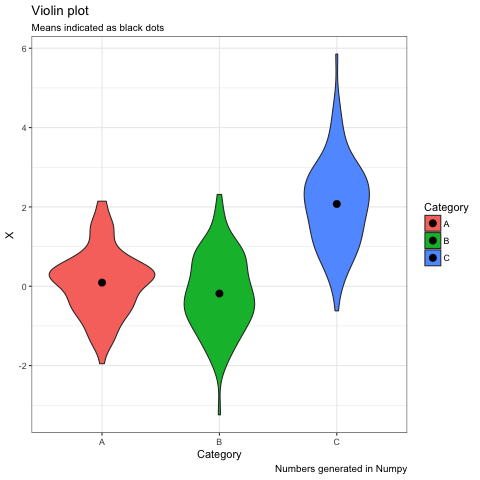

In [26]:
%%R -i df
df %>% 
  gather("Category", "X") %>%
  ggplot(aes(x = Category, y = X, fill = Category)) +
    geom_violin() +
    stat_summary(fun.y=mean, color='black', geom='point', size = 3) +
    labs(title = "Violin plot",
         subtitle = "Means indicated as black dots",
         captions = "Numbers generated in Numpy") +
    theme_bw()

In [ ]:
#TT <- seq(0, 8, length = 501)
#tau <- 2.2
#N0 <- 1000
#a <- 0.25
#f0 <- 8
#Ndet <- N0 * exp(-TT/tau) * (1 + a * cos(f0 * TT))
#N <- Ndet +  rnorm(length(Ndet), mean = Ndet, sd = .01 * max(Ndet))
## make model
#mod <- nlsLM(N ~ N0 * exp(-TT/tau) * (1 + a * cos(f0 * TT)), 
#             start = c(tau = 2.2, N0 = 1500, a = 0.25, f0 = 10), 
#             trace = TRUE)  

#adstockk(trf(kadcyla_calls_1$calls1,0.01),kadcyla_calls_1$ZIP3,0)
#sales1 ~ b1 * adstockk(trf(calls1,alpha1), ZIP3, ad1)

#carryover <- KADCYLA_SALES_SA_L1
#trf <- function(){(1-exp(-r1*KADCYLA_CALLS)) + d1*trf(KADCYLA_CALLS_L1)}
#KADCYLA_SALES ~ b0 + b1*carryover + b2*trf(KADCYLA_CALLS)